In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from scipy.stats import rankdata, levene, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning

from ertk.classification import (
    dataset_cross_validation,
    dataset_train_val_test,
    get_balanced_sample_weights,
    standard_class_scoring,
)
from ertk.config import get_arg_mapping
from ertk.dataset import load_datasets_config, Dataset
from ertk.sklearn.models import get_sk_model
from ertk.sklearn.utils import GridSearchVal
from ertk.train import ExperimentConfig, ValidationSplit, get_cv_splitter, get_scores, scores_to_df

%matplotlib inline
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
esd = Dataset("../../datasets/ESD/corpus.yaml", subset="all")
print(esd)
en_train_idx = esd.get_idx_for_split({"language": ["en"], "split": ["train"]})
en_test_idx = esd.get_idx_for_split({"language": ["en"], "split": ["test"]})
zh_train_idx = esd.get_idx_for_split({"language": ["zh"], "split": ["train"]})
zh_test_idx = esd.get_idx_for_split({"language": ["zh"], "split": ["test"]})

Corpus: ESD
Description: Emotional speech database (ESD)
partition 'gender' (2 groups)
	{'F': 17500, 'M': 17500}
partition 'label' (5 groups)
	{'anger': 7000, 'happiness': 7000, 'neutral': 7000, 'sadness': 7000, 'surprise': 7000}
partition 'language' (2 groups)
	{'en': 17500, 'zh': 17500}
partition 'speaker' (20 groups)
	{'0001': 1750, '0002': 1750, '0003': 1750, '0004': 1750, '0005': 1750, '0006': 1750, '0007': 1750, '0008': 1750, '0009': 1750, '0010': 1750, '0011': 1750, '0012': 1750, '0013': 1750, '0014': 1750, '0015': 1750, '0016': 1750, '0017': 1750, '0018': 1750, '0019': 1750, '0020': 1750}
partition 'split' (3 groups)
	{'evaluation': 2000, 'test': 3000, 'train': 30000}
partition 'transcript' (971 groups)
35000 instances
Subsets:
	*all: 35000 instances
	 train: 30000 instances
	 evaluation: 2000 instances
	 test: 3000 instances
using  (0 features)



In [17]:
clf = get_sk_model("lr", **get_arg_mapping("../../conf/clf/sk/lr/default.yaml"))
clf = Pipeline([("transform", StandardScaler()), ("clf", clf)])
print(clf)
scoring = standard_class_scoring(esd.classes)

METRICS = ["uar", "war", "macrof1"] + [f"{x}_f1" for x in esd.classes]
# FEATURES = "wav2vec_c_mean"
FEATURES = "wav2vec2_audeering_ft_c_mean"

Pipeline(steps=[('transform', StandardScaler()),
                ('clf', LogisticRegression(C=1, multi_class='multinomial'))])


In [18]:
def fit_and_score(clf, x_train, y_train, x_test, y_test):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    scores_df = scores_to_df(get_scores(scoring, y_pred, y_test))
    cm = confusion_matrix(y_test, y_pred, normalize="all")
    return scores_df, cm

## Within-language speaker-dependent

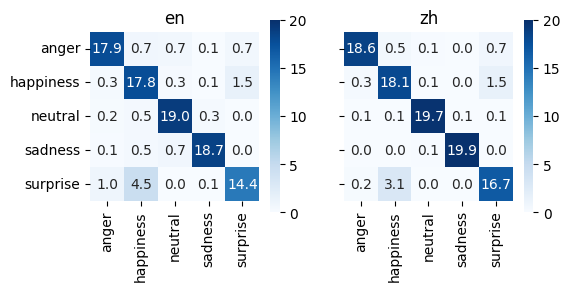

In [19]:
preds = np.load(f"./results/within/{FEATURES}/esd_cross_lang_test/ESD_en_test.preds.npy")[0]
cm_en = pd.DataFrame(confusion_matrix(esd.y[en_test_idx], preds, normalize="all"), index=esd.classes, columns=esd.classes)
en_df = pd.read_csv(f"./results/within/{FEATURES}/esd_cross_lang_test/ESD_en_test.csv", index_col=[0, 1]).mean(numeric_only=True)

preds = np.load(f"./results/within/{FEATURES}/esd_cross_lang_test/ESD_zh_test.preds.npy")[0]
cm_zh = pd.DataFrame(confusion_matrix(esd.y[zh_test_idx], preds, normalize="all"), index=esd.classes, columns=esd.classes)
zh_df = pd.read_csv(f"./results/within/{FEATURES}/esd_cross_lang_test/ESD_zh_test.csv", index_col=[0, 1]).mean(numeric_only=True)

within_sd_df = pd.concat([en_df, zh_df], keys=["en", "zh"]).unstack()

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharex=True, sharey=True)
sns.heatmap(cm_en * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0])
ax[0].set_title("en")
sns.heatmap(cm_zh * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1])
ax[1].set_title("zh")
plt.show()

## Within-language speaker-independent

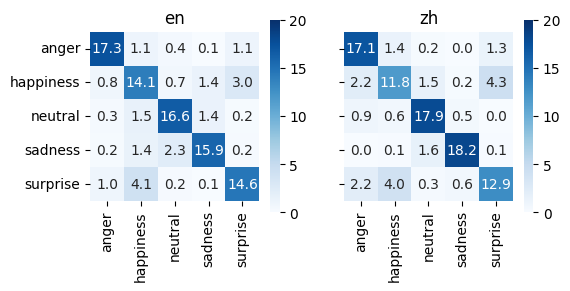

In [20]:
esd.update_features(f"../../features/ESD/{FEATURES}.nc")

sub_x = esd.x[en_train_idx]
sub_y = esd.y[en_train_idx]
sub_spk = esd.speaker_indices[en_train_idx]
cv = LeaveOneGroupOut()
jobs = []
for i, (train, test) in enumerate(cv.split(sub_x, sub_y, sub_spk)):
    jobs.append(delayed(fit_and_score)(clf, sub_x[train], sub_y[train], sub_x[test], sub_y[test]))
res = Parallel(n_jobs=10)(jobs)
scores_df = pd.concat([x[0] for x in res], keys=np.unique(esd.speakers[en_train_idx]))

en_df = scores_df.mean(numeric_only=True)
cm_en = pd.DataFrame(np.mean([x[1] for x in res], axis=0), index=esd.classes, columns=esd.classes)

sub_x = esd.x[zh_train_idx]
sub_y = esd.y[zh_train_idx]
sub_spk = esd.speaker_indices[zh_train_idx]
cv = LeaveOneGroupOut()
jobs = []
for i, (train, test) in enumerate(cv.split(sub_x, sub_y, sub_spk)):
    jobs.append(delayed(fit_and_score)(clf, sub_x[train], sub_y[train], sub_x[test], sub_y[test]))
res = Parallel(n_jobs=10)(jobs)
scores_df = pd.concat([x[0] for x in res], keys=np.unique(esd.speakers[zh_train_idx]))

zh_df = scores_df.mean(numeric_only=True)
cm_zh = pd.DataFrame(np.mean([x[1] for x in res], axis=0), index=esd.classes, columns=esd.classes)

within_si_df = pd.concat([en_df, zh_df], keys=["en", "zh"]).unstack()

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharex=True, sharey=True)
sns.heatmap(cm_en * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0])
ax[0].set_title("en")
sns.heatmap(cm_zh * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1])
ax[1].set_title("zh")
plt.show()

## Cross-language

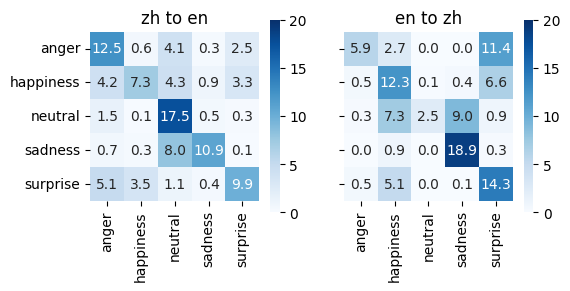

In [21]:
preds = np.load(f"./results/logo/{FEATURES}/esd_cross_lang_test__en.preds.npy")[0]
cm_en = pd.DataFrame(confusion_matrix(esd.y[en_test_idx], preds, normalize="all"), index=esd.classes, columns=esd.classes)
en_df = pd.read_csv(f"./results/logo/{FEATURES}/esd_cross_lang_test__en.csv", index_col=[0, 1]).mean(numeric_only=True)

preds = np.load(f"./results/logo/{FEATURES}/esd_cross_lang_test__zh.preds.npy")[0]
cm_zh = pd.DataFrame(confusion_matrix(esd.y[zh_test_idx], preds, normalize="all"), index=esd.classes, columns=esd.classes)
zh_df = pd.read_csv(f"./results/logo/{FEATURES}/esd_cross_lang_test__zh.csv", index_col=[0, 1]).mean(numeric_only=True)

cross_df = pd.concat([en_df, zh_df], keys=["en", "zh"]).unstack()

fig, ax = plt.subplots(1, 2, figsize=(6, 2.5), sharex=True, sharey=True)
sns.heatmap(cm_en * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[0])
ax[0].set_title("zh to en")
sns.heatmap(cm_zh * 100, vmin=0, vmax=20, cmap="Blues", annot=True, fmt=".1f", square=True, ax=ax[1])
ax[1].set_title("en to zh")
plt.show()

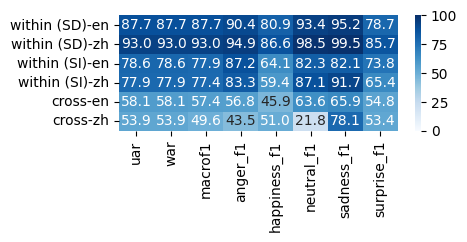

In [22]:
results_df = pd.concat([within_sd_df, within_si_df, cross_df], keys=["within (SD)", "within (SI)", "cross"])
results_df = results_df[METRICS] * 100
fig, ax = plt.subplots(figsize=(4.5, 1.5))
sns.heatmap(results_df, vmin=0, vmax=100, cmap="Blues", annot=True, fmt=".1f", ax=ax)
ax.set_ylabel(None)
plt.show()

In [23]:
print(results_df.diff(2).to_latex(float_format="{:.1f}".format))

\begin{tabular}{llrrrrrrrr}
\toprule
      &    &   uar &   war &  macrof1 &  anger\_f1 &  happiness\_f1 &  neutral\_f1 &  sadness\_f1 &  surprise\_f1 \\
\midrule
within (SD) & en &   NaN &   NaN &      NaN &       NaN &           NaN &         NaN &         NaN &          NaN \\
      & zh &   NaN &   NaN &      NaN &       NaN &           NaN &         NaN &         NaN &          NaN \\
within (SI) & en &  -9.1 &  -9.1 &     -9.8 &      -3.2 &         -16.8 &       -11.1 &       -13.1 &         -4.9 \\
      & zh & -15.1 & -15.1 &    -15.7 &     -11.6 &         -27.2 &       -11.4 &        -7.8 &        -20.3 \\
cross & en & -20.5 & -20.5 &    -20.5 &     -30.5 &         -18.2 &       -18.7 &       -16.3 &        -19.0 \\
      & zh & -24.1 & -24.1 &    -27.8 &     -39.8 &          -8.4 &       -65.3 &       -13.6 &        -12.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3966075/1262426220.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df.diff(2).to_latex(float_format="{:.1f}".format))
